# Reprojecting datacube and raster data <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3)
* **Special requirements:** This notebook loads data from an external raster file (`canberra_dem_250m.tif`) from the `Supplementary_data` folder of this repository


## Background
It is often valuable to combine data from the datacube with other external raster datasets. 
For example, we may want to use a Digital Elevation Model (DEM) raster as a mask to focus our analysis on satellite data from areas of low or high elevation.
However, it can be challenging to combine datasets if they have different extents, resolutions (e.g. 30 m vs. 250 m), or coordinate reference systems (e.g. WGS 84 vs. Australian Albers).
To be able to combine these datasets, we need to be able to *reproject* them into identical spatial grids prior to analysis.

Datacube stores information about the location, resolution and coordinate reference system of a rectangular grid of data using an object called a `GeoBox`.
This `GeoBox` object is added to all data loaded from the datacube, and all rasters loaded with `xr.open_rasterio` (provided that `import datacube` is run *before* the raster is loaded).
Datacube functions can use this object to provide a template that can be used to reproject raster and datacube data - either applying this reprojection directly when new data is being loaded, or to reproject existing data that has already been loaded into memory.
This makes it straightforward to reproject one dataset into the exact spatial grid of another dataset for further analysis.



## Description
This notebook demonstrates how to perform three key reprojection workflows when working with datacube data and external rasters:

1. Loading and reprojecting datacube data to match a raster file using `dc.load`
2. Reprojecting existing datacube data to match a raster using `xr_reproject`
3. Loading and reprojecting a raster to match datacube data using `rio_slurp_xarray`

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import sys
import datacube
import xarray as xr
import matplotlib.pyplot as plt
from odc.algo import xr_reproject
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.masking import mask_invalid_data

sys.path.append("../Scripts")
from dea_plotting import rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Reprojecting_data")

## Loading and reprojecting datacube data to match a raster

### Load a raster file
First we load a GeoTIFF raster from file using `xr.open_rasterio`. 
The example below loads a single band Digital Elevation Model raster for the Canberra region with a low spatial resolution of ~0.002075 decimel degrees (approximately equal to 250 m pixels at the equator) in the WGS 84 (`EPSG:4326`) coordinate reference system.


In [3]:
# Path to raster file
raster_path = "../Supplementary_data/Reprojecting_data/canberra_dem_250m.tif"

# Load raster, and remove redundant "band" dimension
raster = xr.open_rasterio(raster_path).squeeze("band", drop=True)

If we plot our loaded raster, we can see Canberra's Lake Burley Griffin in the centre as an area of low elevation (dark pixels), and nearby areas of higher elevation as brighter pixels (e.g. Mt Ainslie, Black Mountain, Red Hill).
Note that the raster will appear pixelated due to the large ~250 m pixels:

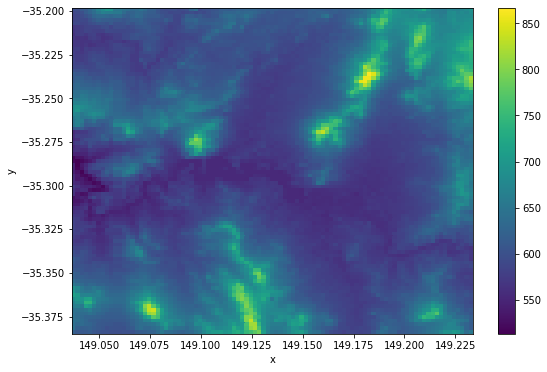

In [4]:
raster.plot(size=6)

### GeoBox objects
Now we have loaded our raster dataset, we can inspect its `GeoBox` object that we will use to allow us to reproject data.
The `GeoBox` can be accessed using the `.geobox` method.
It includes a set of information that together completely define the spatial grid of our data:
* The width (e.g. `95`) and height (e.g. `90`) of our data in pixels
* An `Affine` object which defines the spatial resolution (e.g. `-0.0020751667555555255` and `0.0020769114631576106`) and spatial position (e.g. `149.036528545` and `-35.198132594`) of our data
* The coordinate reference system of our data (e.g. `+init=epsg:4326`)


In [5]:
raster.geobox

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


GeoBox(95, 90, Affine(0.0020769114631576106, 0.0, 149.036528545,
       0.0, -0.0020751667555555255, -35.198132594), +init=epsg:4326)

The `GeoBox` also has a number of useful methods that can be used to view information about the spatial grid of our data.
For example, we can inspect the spatial resolution of our data:

In [6]:
raster.geobox.resolution

(-0.0020751667555555255, 0.0020769114631576106)

Or obtain information about the data's spatial extent:

In [7]:
raster.geobox.extent.boundingbox

BoundingBox(left=149.036528545, bottom=-35.384897601999995, right=149.23383513399997, top=-35.198132594)

> **Note:** For more information about `GeoBox` objects and a complete list of their methods, refer to the [datacube documentation](https://datacube-core.readthedocs.io/en/latest/dev/api/generate/datacube.utils.geometry.GeoBox.html#).

### Load and reproject datacube data
We can now use datacube to load and reproject satellite data to exactly match the coordinate reference system and resolution of our raster data.
By specifying `like=raster.geobox`, we can load datacube data that will be reprojected to match the spatial grid of our raster.

In [8]:
# Load and reproject data from datacube
ds = dc.load(product="ga_ls8c_ard_3",
             measurements=["nbart_red", "nbart_green", "nbart_blue"],
             time=("2019-01-10", "2019-01-15"),
             like=raster.geobox,
             resampling="nearest",
             group_by="solar_day")

When we plot the result, it should appear similarly pixelated to the low resolution raster we loaded above:

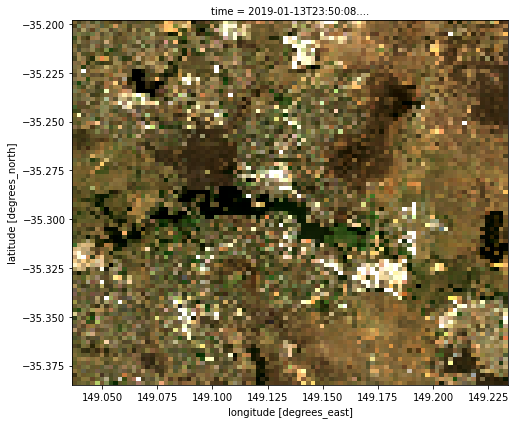

In [9]:
rgb(ds, col='time')

We can also directly compare the geobox of the two datasets to verify they share the same spatial grid:

In [10]:
ds.geobox == raster.geobox

True

Now that our two datasets share the same spatial grid, we can use our raster as a mask.
For example, we can mask out all satellite pixels except those located on hills (e.g. greater than 600 m elevation):

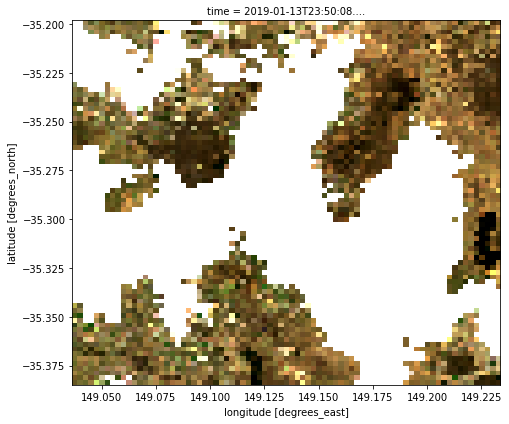

In [11]:
# Rename raster dimensions to match datacube conventions for data
# with geographic coordinates
if raster.geobox.crs.geographic:
    raster = raster.rename({"x": "longitude", "y": "latitude"})

# Identify hilly areas
is_hilly = raster > 600

# # Apply mask to set non-hilly areas to `NaN`
ds_masked = ds.where(is_hilly)

# Plot the masked data
rgb(ds_masked, col="time")

## Reprojecting existing datacube data to match a raster
The example above demonstrated how to load *new* satellite data from the datacube to match the spatial grid of a raster. 
However, sometimes we may have already loaded satellite data with a coordinate reference system and resolution that is different from our raster. 
In this case, we need to reproject this existing dataset to match our raster.

For example, we may have loaded Landsat 8 data from the datacube with 30 m pixels in the Australia Albers (`EPSG:3577`) coordinate reference system (note that in this example we manually specify the `x`, `y`, `resolution` and `output_crs` parameters, rather than taking them directly from our raster using `like=raster.geobox` in the previous example).

In [12]:
# Load data from datacube
ds = dc.load(product="ga_ls8c_ard_3",
             measurements=["nbart_red", "nbart_green", "nbart_blue"],
             time=("2019-01-10", "2019-01-15"),
             x=(149.03, 149.23),
             y=(-35.18, -35.39),
             resolution=(-30, 30),
             output_crs="EPSG:3577",
             group_by="solar_day")

# Load raster, and remove redundant "band" dimension
raster = xr.open_rasterio(raster_path).squeeze("band", drop=True)

If we plot our satellite data, we can see that it is much higher resolution than our pixelated DEM raster:

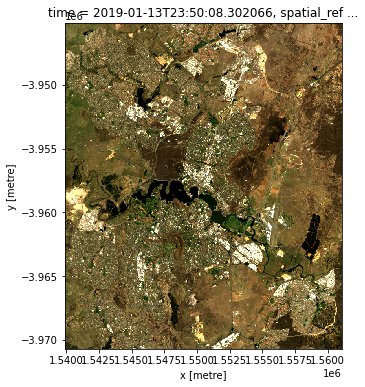

In [13]:
rgb(ds)

### Reproject datacube data
We can now use the `xr_reproject` function to reproject our existing high resolution satellite dataset. 
We specify `geobox=raster.geobox` to request that the data gets reprojected to match the spatial grid of our low resolution raster. 

To control how the data is reprojected, we can specify a custom `resampling` method that will control how our high resolution pixels will be transformed into lower resolution pixels.
In this case, we specify `"average"`, which will set the value of each larger pixel to the average of all smaller pixels that fall within its pixel boundary.

> **Note:** Refer to the [rasterio documentation](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling) for a full list of available resampling methods.

In [14]:
# Temporary workaround for bug in `xr_reproject`
if raster.geobox.crs.geographic:
    ds = ds.rename({"x": "longitude", "y": "latitude"})

# Reproject data
ds_reprojected = xr_reproject(src=ds, 
                              geobox=raster.geobox, 
                              resampling="average")

# Set nodata to `NaN`
ds_reprojected = mask_invalid_data(ds_reprojected)

Now if we plot our reprojected dataset, we can see that our satellite imagery now has a similar resolution to our low resolution raster (e.g. with a pixelated appearance). 
Note however, that this result will appear smoother than the previous example due to the `"average"` resampling method used here (compared to `"nearest"`).

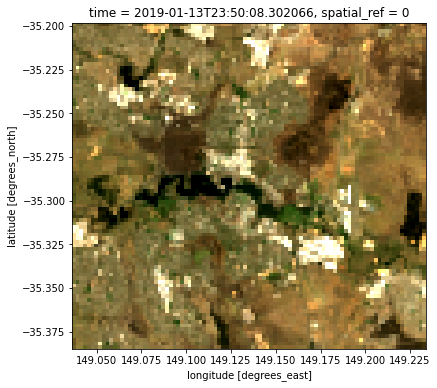

In [15]:
rgb(ds_reprojected)

Once again, we can also verify that the two datasets have identical spatial grids:

In [16]:
ds_reprojected.geobox == raster.geobox

True

## Loading and reprojecting a raster to match datacube data

Rather than reprojecting satellite data to match the resolution and projection system of our raster, we may instead wish to reproject our raster to match the spatial grid of our satellite data.
This can be particularly useful when we have a lower resolution raster file (e.g. like the ~250 m resolution DEM we are using in this example), but we don't want to lose the better spatial resolution of our satellite data. 

### Load datacube data
As in the previous example, we can load in satellite data from the datacube at 30 m spatial resolution and Australian Albers (`EPSG:3577`) coordinate reference system:

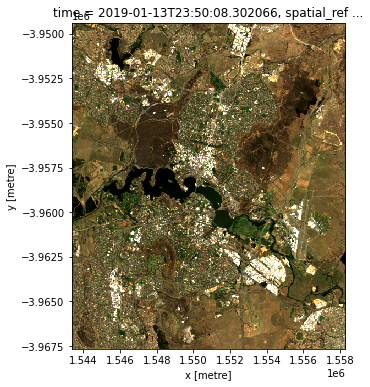

In [17]:
# Load data from datacube
ds = dc.load(product="ga_ls8c_ard_3",
             measurements=["nbart_red", "nbart_green", "nbart_blue"],
             time=("2019-01-10", "2019-01-15"),
             x=(149.064, 149.205),
             y=(-35.215, -35.365),
             resolution=(-30, 30),
             output_crs="EPSG:3577",
             group_by="solar_day")

# Plot 30 m resolution satellite data
rgb(ds)

### Load and reproject raster data
We can now use the `rio_slurp_xarray` function to load and reproject our raster file to match our higher resolution satellite dataset.
We specify `gbox=ds.geobox` to request that our raster gets reprojected to match the spatial grid of `ds`.
As in the previous `xr_reproject` example, we can also specify a custom `resampling` method which will be used during the reprojection.
In this case, we specify `'bilinear'`, which will produce a smooth output without obvious pixel boundaries.

> **Note:** Refer to the [rasterio documentation](https://rasterio.readthedocs.io/en/latest/api/rasterio.enums.html#rasterio.enums.Resampling) for a full list of available resampling methods.

In [18]:
# Load raster and reproject to match satellite dataset
raster_reprojected = rio_slurp_xarray(fname=raster_path,
                                      gbox=ds.geobox,
                                      resampling="bilinear")

# Set nodata to `NaN`
raster_reprojected = mask_invalid_data(raster_reprojected)

If we plot our resampled raster data, it should now appear less pixelated than the original ~250 m resolution raster.

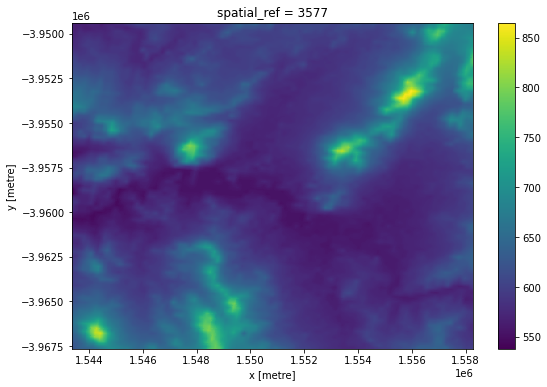

In [19]:
raster_reprojected.plot(size=6)

The resampled raster should also match the spatial grid of our higher resolution satellite data:

In [20]:
raster_reprojected.geobox == ds.geobox

True

Now both of our datasets share the same spatial grid, we can use our resampled raster to mask our higher resolution satellite dataset as we did in the first section (e.g. mask out all areas lower than 600 m elevation). 
Compared to the first example, this masked satellite dataset should appear much higher resolution, with far less obvious pixelation:

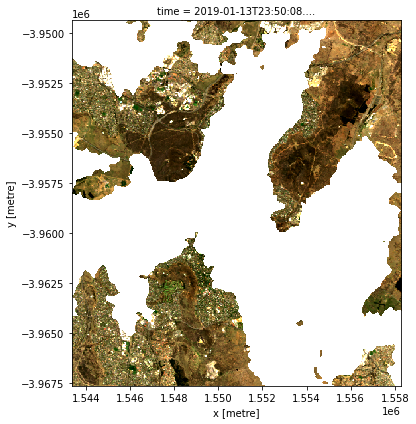

In [21]:
# Identify hilly areas
is_hilly = raster_reprojected > 600

# Apply mask to set non-hilly areas to `NaN`
ds_masked = ds.where(is_hilly)

# Plot the masked data
rgb(ds_masked, col='time')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020

**Compatible datacube version:** 

In [22]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)